
# Background Note 

# Descriptive Statistics: Simple Ordinary Least Squares

# By Albert S. Kyle

$\def \sm {} \renewcommand{\sm}{ {\scriptstyle{\text{*}}}}$ 
$\def \mm {} \renewcommand{\mm}{{\scriptsize @}}$
$\def \E {} \renewcommand{\E}{\mathrm{E}}$
$\def \e {} \renewcommand{\e}{\mathrm{e}}$
$\def \drm {} \renewcommand{\drm}{\mathrm{\, d}}$
$\def \var {} \renewcommand{\var}{\mathrm{var}}$
$\def \cov {} \renewcommand{\cov}{\mathrm{cov}}$
$\def \corr {} \renewcommand{\corr}{\mathrm{corr}}$
$\def \stdev {} \renewcommand{\stdev}{\mathrm{stdev}}$
$\def \t {} \renewcommand{\t}{^{\mathsf{T}}}$
$\def \comma {} \renewcommand{\comma}{\, , \,}$
$\def \vec {} \renewcommand{\vec}[1]{\mathbf{#1}}$
$\def \skew {} \renewcommand{\skew}{\mathrm{skew}}$
$\def \kurt {} \renewcommand{\kurt}{\mathrm{kurt}}$
$\def \prob {} \renewcommand{\prob}{\textrm{prob}}$
$\def \midx {} \renewcommand{\midx}{\, \mid \,}$
$\def \argmin {} \renewcommand{\argmin}[1]{\underset{#1}{\mathrm{argmin}}}$


In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import sys
import datetime
import timeit
import math
import statistics
import nbconvert

print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('NumPy version ' + np.__version__)
print('SciPy version ' + scipy.__version__)
print('matplotlib version ' + matplotlib.__version__)

timestamp = datetime.datetime.now().strftime('%Y-%m%d-%H%M')
print("Timestamp:", timestamp)
tstart = timeit.default_timer()


Python version 3.11.7 | packaged by conda-forge | (main, Dec 23 2023, 14:27:59) [MSC v.1937 64 bit (AMD64)]
Pandas version 2.2.0
NumPy version 1.26.3
SciPy version 1.12.0
matplotlib version 3.8.2
Timestamp: 2024-0905-1201


### Descriptive Problem: Fit a line to data

Let $\vec{x} = (\vec{x}[0], \ldots, \vec{x}[N-1])$ and $\vec{y}=(\vec{y}[0], \ldots, \vec{y}[N-1])$ denote two vectors of length $N$.

The following cell generates some data and plots the points. 

You can look at the definition of the function `f_generate_data(N)` and see that the data is generated from a **simple linear regression model** of the form $\vec{y}[n] = \alpha + \beta \sm \vec{x}[n] + \pmb{\epsilon}[n]$. Here "simple" means that there is one x-variable (plus a constant term); "linear" means that, when the error is ignored, what remains $ \alpha + \beta \sm \vec{x}[n]$ is a linear function of $\vec{x}[n]$, and "regression model" means that a random error $\pmb{\epsilon}[n]$ (not correlated with $\vec{x}[n]$) has been added to the linear function so that $ \alpha + \beta \sm \vec{x}[n]$ cannot be inferred perfectly from $\vec{x}[n]$.  Further inspection of the function would show that the errors $\pmb{\epsilon} = (\pmb{\epsilon}[0], \ldots, \pmb{\epsilon}[N-1])$ are drawn from a normal distribution and are independently distributed from $\alpha$, $\beta$, and $\vec{x}[n]$. Furthermore, $\alpha$, $\beta$, and the error standard deviation $\sigma$ are constants generated by a random number generator (which captures the idea that we do not know these values in advance of looking at the data).

Suppose for now that you do not know the definition of this function; you can only see its output of vectors `x`, `y` plotted in the next cell.


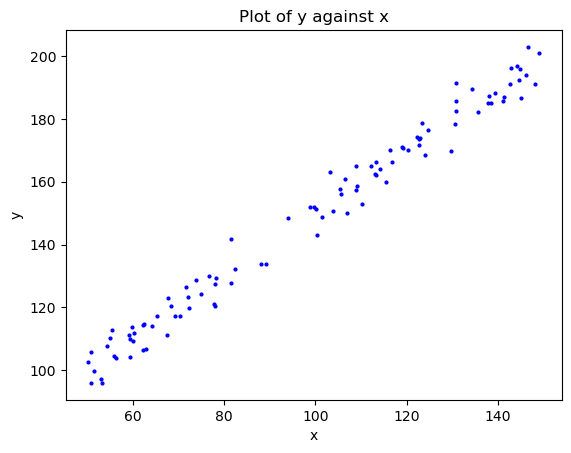

In [2]:
def f_generate_data(N):

    rng = np.random.default_rng(seed=1234)
    alpha = rng.normal(loc=80.00, scale=20.00, size=1)[0]
    beta = rng.normal(loc=1.00, scale=0.20, size=1)[0]
    sigma = rng.uniform(low=2.00, high=4.00, size=1)[0]
    epsilon = sigma * rng.standard_normal(N)

    xmin, xmax = 50.00, 150.00
    x = rng.uniform(low=xmin, high=xmax, size=N)
    y = alpha + x * beta + epsilon

    #print(f"{alpha=}, {beta=}, {sigma=},")
    
    return x, y

N = 100
x, y = f_generate_data(N)
    
fig, ax = plt.subplots(1, 1)
ax.set_title("Plot of y against x")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.plot(x, y, 'bo', ms=2.00, label= None)
# ax.vlines(ns, 0, freqns, colors='r', lw=1, alpha=0.5)
# ax.legend(loc='best', frameon=False)
# plt.show()



### Ordinary Least Squares: Minimizing mean squared error

Visual inspection suggests that the data are well-described by a straight line of the form $\vec{y}[n] \approx a + b \sm \vec{x}[n]$, $n=0$, $\ldots$, $N-1$.

We would like to draw a line through a plot of the $N$ points in the X, Y plane such that the line fits the points well. 

A standard way to make this problem precise is to minimize the sum of squared vertical distances between the $N$ points $\vec{x}[n], \vec{y}[n]$, and the line itself.  This approach, which minimizes **mean squared error** (after dividing the sum of squared errors by $N$), is called **ordinary least squares** (**OLS**). "Ordinary" means that the same weight is put on the square of each error, and "least squares" means that the sum of squared errors is being minimized.

Here we are using OLS as a way to describe data without making any statistical or probabilistic assumptions about how the data are generated. In this sense, we are not (consciously) "estimating a linear regression model," even though the data was in fact generated by a linear regression model.

Mathematically, our problem is to choose intercept parameter $a$ and slope parameter $b$ to minimize the squared differences between the **dependent variables** $\vec{y}$ and the **predictions** $\hat{\vec{y}} := a + b \sm \vec{x}$ based on the **independent variables** $\vec{x}$.

### Objective Function

Define an **objective function** $f_{obj}( a, b ; \vec{x}, \vec{y} )$, which defines the sum of squared errors, by

\begin{equation}
f_{obj}( a, b ; \vec{x}, \vec{y} ) = \sum_{n=0}^{N-1} \left( \vec{y}[n] - a - b \sm \vec{x}[n] \right)^2 .
\end{equation}

The semicolon in the notation $f_{obj}( a, b ; \vec{x}, \vec{y} )$ conveys the idea that $f_{obj}$ is a function of the two parameters $a$ and $b$, while $\vec{x}$ and $\vec{y}$ are fixed inputs which this function depends on.  This way of thinking about objective functions permeates finance modeling and Python optimization (even though an explicit semi-colon is not used).

Our problem is to find the values of the parameters $a$ and $b$ to minimize the objective function. We write this problem as

\begin{equation}
\hat{a}, \hat{b} = \argmin{a,b}  \left[ f_{obj}( a, b ; \vec{x}, \vec{y} ) \right] ,
\end{equation}

where $\hat{a}, \hat{b}$ are the values of the parameters (before the semicolon) which minimize the objective function.

In vector notation, this minimization problem can be written

\begin{equation}
\hat{a}, \hat{b}
= \argmin{a,b} \left( \vec{y} - a - b \sm \vec{x} \right) \t \mm \left( \vec{y} - a - b \sm \vec{x} \right) 
\end{equation}

### OLS Solution

At the minimum, the **partial derivatives** with respect to $a$ and $b$ must be zero.  This gives us the first-order conditions for $a$ and $b$, respectively:

\begin{equation}
\frac{\partial f_{obj}}{\partial a}(\hat{a}, \hat{b}) = 2 \sm \sum_{n=0}^{N-1} \left( \vec{y}[n] - \hat{a} - \hat{b} \sm \vec{x}[n] \right) = 0,
\qquad
\frac{\partial f_{obj}}{\partial b}(\hat{a}, \hat{b}) = 2 \sm \sum_{n=0}^{N-1} \left( \vec{y}[n] - \hat{a} - \hat{b} \sm \vec{x}[n] \right) \sm \vec{x}[n] = 0.
\end{equation}

It is easy to solve this system of two equations for the two unknowns $\hat{a}$ and $\hat{b}$ by hand. First, let $\bar{x}$ and $\bar{y}$ denote the sample means of $x$ and $y$: 

\begin{equation}
\bar{\vec{x}} := \tfrac{1}{N} \sm \sum_{n=0}^{N-1} \vec{x}[n], \qquad  \bar{y} := \tfrac{1}{N} \sm \sum_{n=0}^{N-1} \vec{y}[n].
\end{equation} 

The solutions is

\begin{equation}
\hat{b} = \frac{ \sum_{n=0}^{N-1} \left( \vec{x}[n] -\bar{\vec{x}} \right) \sm \left( \vec{y}[n] - \bar{\vec{y}} \right) }{ \sum_{n=0}^{N-1} \left( \vec{x}[n] -\bar{\vec{x}} \right)^2 } ,
\qquad
\hat{a} = \bar{y} - \hat{b} \sm \bar{x}
\end{equation}

It is easy to see that this solution is the desired minimum of the objective function and not a maximum: The objective function is a quadratic function of $a$ and $b$, which is always nonnegative.  The objective is zero if the fit is perfect (which would correspond to $\sigma=0$).

### Simple OLS: Root mean squared error of the estimate, R-squared

We would also like to define some simple measures of goodness of fit.

The **sum of squared errors** (**SSE**) of the predictions is defined as the value of the objective function at the optimum:

\begin{align}
\text{SSE} :&= f_{obj}(\hat{a}, \hat{b})\\ 
&=  \sum_{n=0}^{N-1} \left( \vec{y}[n] - \hat{\vec{y}}[n] \right)^2 \\
&= (\vec{y} - \hat{\vec{y}}) \t \mm (\vec{y} - \hat{\vec{y}}).
\end{align}

The **root mean squared error** of the predictions is defined as

\begin{equation}
\text{RMSE} := \sqrt{ \frac{\text{SSE}}{N} } .
\end{equation}

The root mean squared error has the same units as $\vec{y}[n]$ and $\hat{\vec{y}}[n]$. It measures the "typical" vertical distance between points $\vec{y}[n]$ and their estimates $\hat{\vec{y}}[n]$.

The **sample coefficient of determination** (**R-squared** or **$\text{R}^2$**) is defined as

\begin{align}
r_{xy}^2 :&= 1 - \frac{\text{SSE}}{\sum_{n=0}^{N-1} (\vec{y}[n] - \bar{\vec{y}})^2 } \\
&=  1 - \frac{(\vec{y} - \hat{\vec{y}}) \t \mm (\vec{y} - \hat{\vec{y}})}{(\vec{y} - \bar{\vec{y}}) \t \mm (\vec{y} - \bar{\vec{y}}) } .
\end{align}

The **sample correlation coefficient** between $\vec{x}$ and $\vec{y}$ is defined as

\begin{equation}
r_{xy} = \frac{\sum_{n=0}^{N-1} ( \vec{x}[n] - \bar{\vec{x}} ) \sm (\vec{y}[n] - \bar{\vec{y}}) }{\sqrt{\sum_{n=0}^{N-1} (\vec{x}[n] - \bar{\vec{x}})^2} \sm \sqrt{\sum_{n=0}^{N-1} (\vec{y}[n] - \bar{\vec{y}})^2 }} .
\end{equation}

The regression coefficient is equal to the sample correlation coefficient when the sample correlation coefficient is rescaled by the sample standard deviations of $\vec{x}$ and $\vec{y}$:

\begin{equation}
\hat{b} = r_{xy} \sm \frac{s_y}{s_x}, 
\quad \text{where} \quad 
s_x = \sqrt{\tfrac{1}{N} \sm \sum_{n=0}^{N-1} (\vec{x}[n] - \bar{\vec{x}})^2},  
\quad
s_y = \sqrt{\tfrac{1}{N} \sm \sum_{n=0}^{N-1} (\vec{y}[n] - \bar{\vec{y}})^2}  .
\end{equation}

(Obviously if the fraction $\tfrac{1}{N}$ is changed to $\tfrac{1}{N-1}$ in both the numerator and the denominator, the calculation is unchanged.)

The sample correlation coefficient $r_{xy}$ and sample R-squared $r_{xy}^2$ satisfy 

\begin{equation}
r_{xy}^2 = (r_{xy})^2, \qquad -1 \le r_{xy} \le 1, \qquad 0 \le r_{xy}^2 \le 1 .
\end{equation}



### Plot results

There are many ways to calculate the results using Python and Numpy. Here we use the inner product of vectors `np.dot()`. 

Here is a plot of the points (blue dots) and the fitted line (red dots).  Also shown is the fitted line shifted up and down by two times the root mean squared error (thin red dots).  The plot shows that all except a handful of points lie between lines defined by the thin red dots.

x.shape=(100,), y.shape=(100,)
xbar=98.54450667942834, ybar=148.37650482699362, bhat=0.9962569074380566, ahat=50.20085935753744
sse=1852.349991588179, rmse=4.303893576272744, rxy=0.9906575030852217, r2=0.9814022884190319, r2check=0.9814022884190461


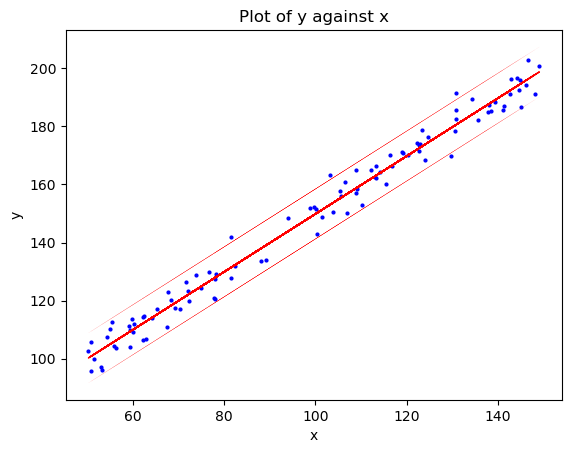

In [3]:

N = 100
x, y = f_generate_data(N)

def f_simple_ols(x, y):
    assert x.shape == y.shape
    assert len(x.shape) == 1
    xbar = x.mean()
    ybar = y.mean()
    dx = x - xbar
    dy = y - ybar
    bhat = np.dot(dx, dy) / np.dot(dx, dx)
    ahat = ybar - bhat * xbar
    yhat = ahat + bhat * x
    residuals = y - yhat
    sse = np.dot(residuals, residuals)  # sum of squared errors
    rmse = np.sqrt(sse / N)  # root mean squared error
    r2 = 1.00 - sse / np.dot(dy, dy) # r-squared
    # correlation coefficient rxy calculated differently (and inefficiently) as a check:
    rxy = ((x * y).mean() - x.mean() * y.mean()) / np.sqrt( ((x**2).mean() - x.mean()**2) * ((y**2).mean() - y.mean()**2))
    r2check = rxy**2
    return xbar, ybar, ahat, bhat, yhat, residuals, sse, rmse, r2, rxy, r2check
    
xbar, ybar, ahat, bhat, yhat, residuals, sse, rmse, r2, rxy, r2check = f_simple_ols(x, y)    
    
print(f"{x.shape=}, {y.shape=}")
print(f"{xbar=}, {ybar=}, {bhat=}, {ahat=}")
print(f"{sse=}, {rmse=}, {rxy=}, {r2=}, {r2check=}")
#print(f"{yhat=}")
#print(f"{residuals=}")

fig, ax = plt.subplots(1, 1)
ax.set_title("Plot of y against x")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.plot(x, y, 'bo', ms=2.00, label= None)
ax.plot(x, yhat, 'r-', ms=2.00, lw=1.00, label= None)
ax.plot(x, yhat + 2.00 * rmse, 'r-', lw=0.01, label= None)
ax.plot(x, yhat - 2.00 * rmse, 'r-', lw=0.01, label= None)
# ax.vlines(ns, 0, freqns, colors='r', lw=1, alpha=0.5)
# ax.legend(loc='best', frameon=False)
# plt.show()



### Exercise 1 (Easy)

1. Calculate the regression coefficient $\hat{b}$ as a ratio using `np.cov(...)` to `np.var(...)`.  

2. Calculate the regression coefficient $\hat{b}$ using only `np.cov`.

3. Explain in one sentence how the parameter `ddof` matters or does not matter for the calculations.

Hints: 

1. The function `np.cov(x, y)` returns a covariance matrix, which in this case is $2 \times 2$. The covariance you need is not on the diagonal of this matrix.  The variance you need is on the diagonal.

2. Both `np.cov` and `np.var` take a parameter `ddof` which corrects for degrees of freedom. You may need to play with this parameter to obtain the precisely correct answer by making `ddof` in the numerator consistent with `ddof` in the denominator.


### Exercise 2 (easy)

1. Edit the function `f_generate_data` to obtain a result that such that the $r^2$ of the OLS estimate is about 0.9999.

1. Edit the function `f_generate_data` to obtain a result that such that the $r^2$ of the OLS estimate is about 0.50.

Hint: Simply change some of the parameters used to generate the data.



In [4]:
timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
tfinish = timeit.default_timer()
print(f"Finished: {timestamp = }\nExecution time = {tfinish - tstart} s")


Finished: timestamp = '2024-09-05 12:01:29'
Execution time = 0.6597336998675019 s
